# Forecasting problems

Here we can find different approaches to forecast 3 different consumer package goods products, from statistics to deep learning models.

- Producto A: Natural organic health product - Peru     - Monthly
- Producto B: Coffee-based drink             - Colombia - Monthly
- Producto C: Carbonated beverage (soda)     - Ecuador  - Daily

In [14]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('src/forecast/')
import statistics

from statistical import StatisticalModel, plot_decomposition, print_adf_test, prepare_exog
from deeplearning import DeepLearningModel, scale_data, time_series_to_X_y
from automl import AutoMLModel, plot_prophet_predictions

from utils import *

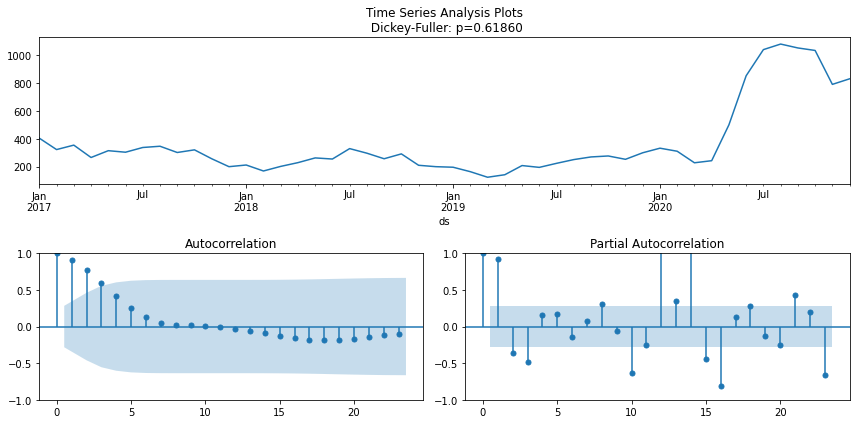

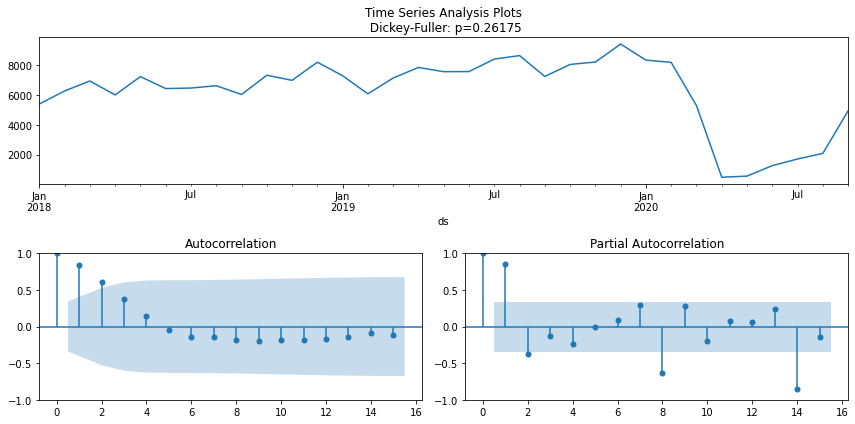

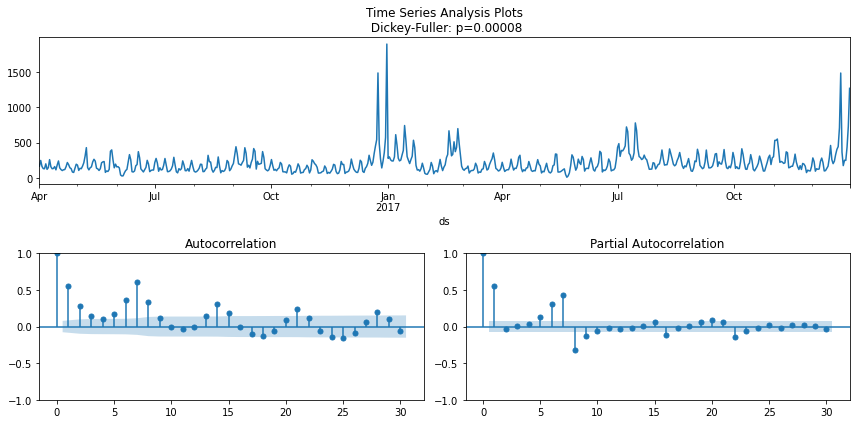

In [3]:
df_paths = ["data/producto_A.csv", "data/producto_B.csv", "data/producto_C.csv"]

for i in df_paths:
    df = get_data(i)
    df.set_index("ds", inplace=True)
    max_lags = min(int(len(df) / 2) - 1, 30)
    tsplot(df.y, lags=max_lags)

## Producto A
Monthly demand forecast for natural organic health product sold through retail channels in Peru. 

In [2]:
df = get_data("data/producto_A.csv")
df.shape

(48, 2)

### Statistical Model (SARIMA)

In [3]:
N_TEST = 4
df.set_index("ds", inplace=True)
y_train, y_test = df["y"][:-N_TEST], df["y"][-N_TEST:]

 - Autoarima approach

--- ADF test ---
ADF Statistic: -0.918 
p-value: 0.782


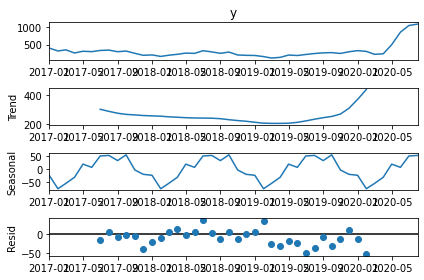

In [4]:
# Test for stationarity / unit roots (Augmented Dickey Fuller Test)
# Arima models needs the input data to be stationary, so p-value need to be < 0.05
print_adf_test(y_train)

plot_decomposition(y_train, period=12)

In [5]:
# With the first difference the data is stationary
y_diff = y_train.to_numpy()[:-1] - y_train.to_numpy()[1:]
print_adf_test(y_diff[1:])

--- ADF test ---
ADF Statistic: -3.669 
p-value: 0.005


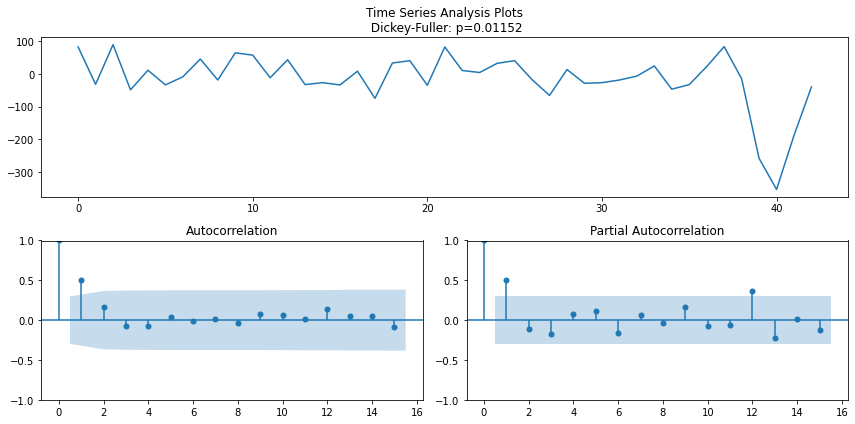

In [6]:
# ACF and PACF plots to have an idea of p and q parameters of ARIMA model
tsplot(y_diff, lags=15)

In [7]:
# Run and auto ARIMA model, it test different parameters and select the best one
# in terms of Akaike Information Criteria (AIC)

m1 = StatisticalModel("auto_arima")
m1.auto_arima(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=489.450, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=490.982, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=491.917, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=489.446, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=485.949, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=487.006, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=487.422, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=485.995, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=492.007, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.384 seconds


In [8]:
results = m1.fit_auto_arima(y_train)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   44
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -239.975
Date:                Sun, 09 Jan 2022   AIC                            485.949
Time:                        21:43:46   BIC                            491.162
Sample:                             0   HQIC                           487.860
                                 - 44                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4668      0.266      1.756      0.079      -0.054       0.988
ma.L1         -0.9187      0.216     -4.248      0.000      -1.343      -0.495
sigma2      5256.4237    896.611      5.863      0.000    3499.098    7013.750
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                17.28
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               2.56   Skew:                             1.17
Prob(H) (two-sided):                  0.09   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE: 329.43
MAPE: 32.44%


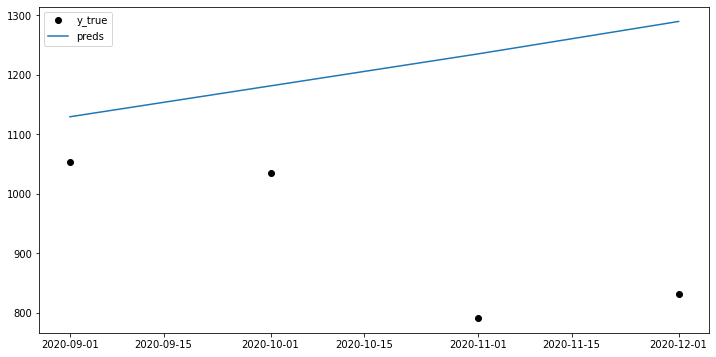

In [9]:
preds = m1.predict(n_periods=N_TEST)
preds = pd.DataFrame(data=preds, columns=["Preds"])
preds.index = y_test.index

print_metrics(y_test.to_numpy(), preds.to_numpy(), None)
plot_predictions(y_test, preds)

- SARIMAX (With COVID-flag exogenous variable)

In [10]:
# With SARIMAX we can add the influence of seasonalities and exogenous variables
# Since there is a big change of the trend in the last months of the time series
# a binary variable (COOVID-19 flag) is addedd to the model

covid = pd.DataFrame(
    {
        "ds": df.index.to_numpy(),
        "y": np.concatenate([np.zeros(len(df) - 8), np.ones(8)]),
    }
).set_index("ds")

exog = prepare_exog(covid.y)
exog_train, exog_test = exog[:-N_TEST], exog[-N_TEST:]

In [14]:
# Custom GridSearch for SARIMAX

max_order = [0, 1] # Due to acf and pacf plots
max_seasonal_order = [0, 1, 2]
max_diff_order = [0, 1]

orders = [(p, d, q) for p in max_order for d in max_diff_order for q in max_order]
seasonal_orders = [(p, d, q, 12) for p in max_seasonal_order for d in max_diff_order for q in max_seasonal_order]

scores = []

for order in orders:
    for seasonal_order in seasonal_orders:
        m = StatisticalModel("SARIMAX")
        res = m.fit_SARIMAX(
            y_train,
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
        )
        preds = res.get_forecast(steps=N_TEST, exog=exog_test).predicted_mean
        scores.append([order, seasonal_order, rmse(y_test, preds)])

scores = pd.DataFrame(scores, columns=["order", "seasonal_order", "rmse"])
scores.sort_values(by="rmse", inplace=True)
scores.head()

In [16]:
m2 = StatisticalModel('SARIMAX')
res = m2.fit_SARIMAX(y_train, exog=exog_train, order=(1, 0, 0), seasonal_order=(2, 1, 2, 12))
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   44
Model:             SARIMAX(1, 0, 0)x(2, 1, [1, 2], 12)   Log Likelihood                -190.436
Date:                                 Sun, 09 Jan 2022   AIC                            396.871
Time:                                         21:45:52   BIC                            408.597
Sample:                                     01-01-2017   HQIC                           400.758
                                          - 08-01-2020                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8829   1175.746     -0.001      0.999   -2305.303    2303.537
y            208.4435    814.822      0.256      0.798   -1388.579    1805.466
ar.L1          0.8528      0.150      5.672      0.000       0.558       1.147
ar.S.L12       1.7298   2744.430      0.001      0.999   -5377.254    5380.714
ar.S.L24      -0.7308   2132.936     -0.000      1.000   -4181.208    4179.747
ma.S.L12      -1.8410   2742.890     -0.001      0.999   -5377.807    5374.125
ma.S.L24       0.8413   2441.059      0.000      1.000   -4783.545    4785.228
sigma2      6095.6907      1.922   3172.305      0.000    6091.925    6099.457
===================================================================================
Ljung-Box (L1) (Q):                   4.28   Jarque-Bera (JB):                94.66
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               7.86   Skew:                             2.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.57e+23. Standard errors may be unstable.
"""

RMSE: 88.29
MAPE: 14.82%


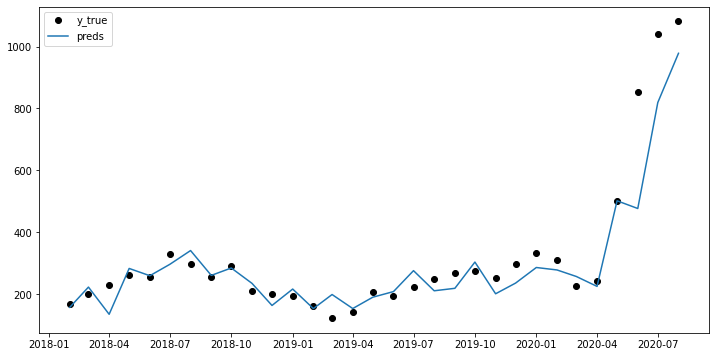

In [17]:
preds_train = res.get_prediction().predicted_mean[13:]
y_train_ = y_train[13:]
print_metrics(y_train_, preds_train, None)
plot_predictions(y_train_, preds_train)

RMSE: 60.75
MAPE: 5.27%


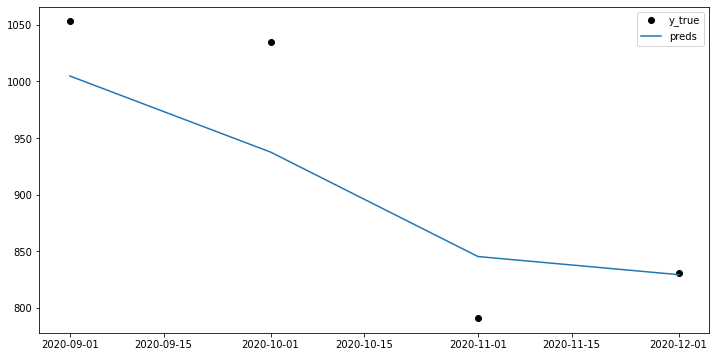

In [18]:
preds = res.get_forecast(steps=N_TEST, exog=exog_test).predicted_mean
print_metrics(y_test, preds, None)
plot_predictions(y_test, preds)

## Producto B:
Montly demand forecast for coffee-based drink sold through channel stores in Colombia.

In [103]:
df = get_data("data/producto_B.csv")
df.shape

(33, 2)

In [104]:
N_TEST = 2
N_FORECAST = 4
df.set_index("ds", inplace=True)
y_train, y_test = df["y"][:-N_TEST], df["y"][-N_TEST:]

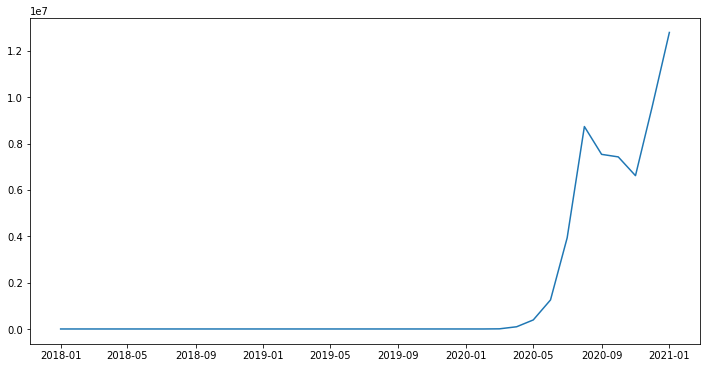

In [105]:
# In this time, I recolect the data of confirmed new cases of COVID-19 in Colombia
# but it didn't work well because its trend is increasing exponentially
# so I decided to use it with another variable, a flag for the first 3 months, 
# when almost all supply chains were disrupted
from deeplearning import scale_data

new_cases = get_covid_data("Colombia", start=df.index.min(), end="2021-01-01")

# Scale the data to be between 0 and 1 to have a better fit with the model
new_cases_scaled, scaler = scale_data([new_cases.new_cases.to_numpy().reshape(-1, 1)], "minmax")
new_cases.new_cases = new_cases_scaled[0]

covid_first_months = pd.DataFrame(
    {
        "ds": pd.date_range(start=df.index.min(), end="2021-01-01", freq="MS"),
        "covid_fm": np.concatenate(
            [np.zeros(len(df) - 6), np.ones(3), np.zeros(7)]
        ).astype(int),
    }
).set_index("ds")

exog_vars = pd.concat([covid_first_months, new_cases], axis=1)

exog_train = prepare_exog(exog_vars[:-(N_TEST + N_FORECAST)])
exog_test = prepare_exog(exog_vars[-(N_TEST + N_FORECAST):-N_FORECAST])
exog_forecast = prepare_exog(exog_vars[-N_FORECAST:])
exog_vars = prepare_exog(exog_vars[:-N_FORECAST])

In [106]:
print_adf_test(y_train[1:])

--- ADF test ---
ADF Statistic: -1.252 
p-value: 0.651


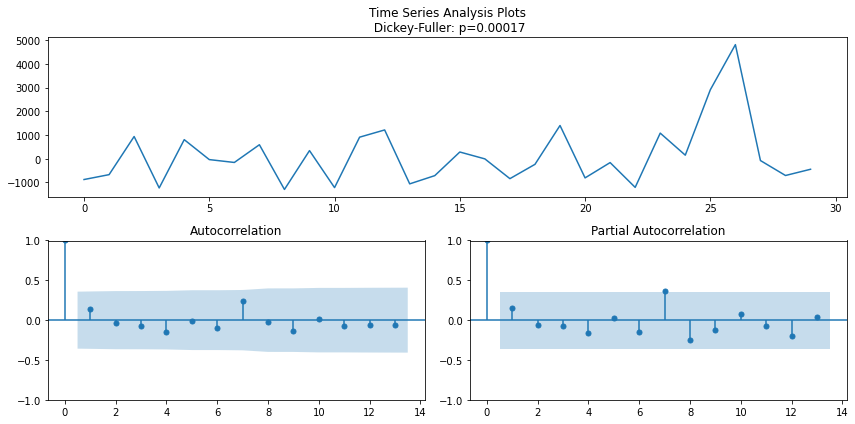

In [30]:
y_diff = y_train.to_numpy()[:-1] - y_train.to_numpy()[1:]
tsplot(y_diff, lags=13)

In [63]:
# Custom GridSearch for SARIMAX

max_order = [0, 1] # Due to acf and pacf plots
max_seasonal_order = [0, 1, 2]
max_diff_order = [0, 1]

orders = [(p, d, q) for p in max_order for d in max_diff_order for q in max_order]
seasonal_orders = [(p, d, q, 12) for p in max_seasonal_order for d in max_diff_order for q in max_seasonal_order]

scores = []

for order in orders:
    for seasonal_order in seasonal_orders:
        m = StatisticalModel("SARIMAX")
        res = m.fit_SARIMAX(
            y_train,
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
        )
        preds = res.get_forecast(steps=N_TEST, exog=exog_test).predicted_mean
        scores.append([order, seasonal_order, rmse(y_test, preds)])

scores = pd.DataFrame(scores, columns=["order", "seasonal_order", "rmse"])
scores.sort_values(by="rmse", inplace=True)
scores.head()

,order,seasonal_order,rmse
109,"(1, 1, 0)","(0, 0, 1, 12)",6234.009361
55,"(0, 1, 1)","(0, 0, 1, 12)",6277.661669
115,"(1, 1, 0)","(1, 0, 1, 12)",6362.531439
122,"(1, 1, 0)","(2, 0, 2, 12)",6385.714869
127,"(1, 1, 1)","(0, 0, 1, 12)",6390.866697


In [107]:
m2 = StatisticalModel('SARIMAX')
res = m2.fit_SARIMAX(y_train, exog=exog_train, order=(1, 1, 0), seasonal_order=(0, 0, 1, 12))
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   31
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -248.626
Date:                              Mon, 10 Jan 2022   AIC                            509.252
Time:                                      19:58:49   BIC                            517.659
Sample:                                  01-01-2018   HQIC                           511.942
                                       - 07-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5928   4893.999      0.001      0.999   -9585.468    9598.654
covid_fm   -4607.3446   1906.417     -2.417      0.016   -8343.852    -870.837
new_cases  -1.481e+04   6657.035     -2.225      0.026   -2.79e+04   -1762.750
ar.L1         -0.1923      0.203     -0.949      0.343      -0.590       0.205
ma.S.L12      -0.9991      0.300     -3.327      0.001      -1.588      -0.410
sigma2      5.642e+05      0.091   6.22e+06      0.000    5.64e+05    5.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.78   Prob(JB):                         0.44
Heteroskedasticity (H):               2.75   Skew:                            -0.57
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.53e+25. Standard errors may be unstable.
"""

RMSE: 1015.71
MAPE: 27.37%


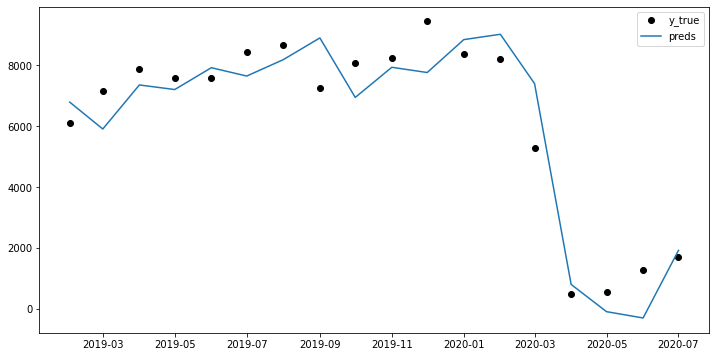

In [108]:
preds_train = res.get_prediction().predicted_mean[13:]
y_train_ = y_train[13:]
print_metrics(y_train_, preds_train, None)
plot_predictions(y_train_, preds_train)

RMSE: 6234.01
MAPE: 209.84%


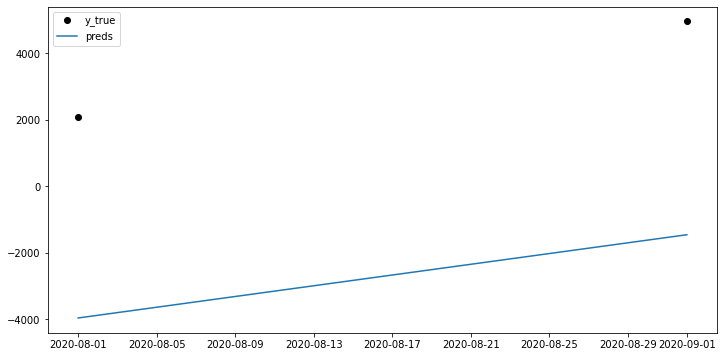

In [109]:
# We can see that the model has a moderate fit on the training data,
# but the model is not able to capture the real influence of the new cases variable,
# so when new cases growth significantly, the model will be affected and the forecaste will be biased 
# however, the model is able to capture the trend of the data but with negative values (-6000 aprox in each point vs actuals)

preds = res.get_forecast(steps=N_TEST, exog=exog_test).predicted_mean
print_metrics(y_test, preds, None)
plot_predictions(y_test, preds)

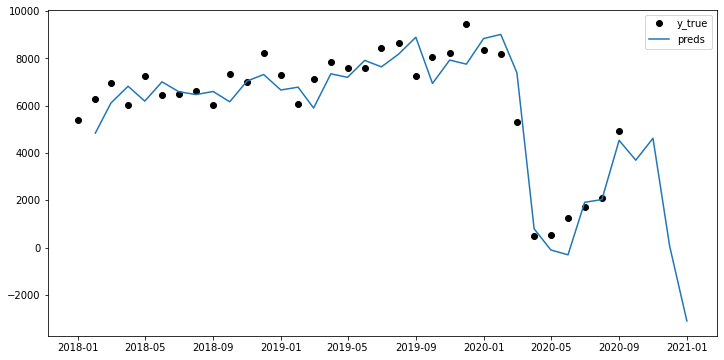

In [112]:
# We try to use this model and forecast the next 4 months with the +6000 biased forecast
# but it doesn't wotk as we see in the plot.
# If we analyze visually the data, we can se a big dropout in the first months of the COVID-19
# but its trend is recovering faster as well, so I suggest to just use a simple regression model
# takeing the first months of data until the dropout and use it as a base for the model

preds_train = res.get_prediction().predicted_mean[1:]
exog_forecast = pd.concat([exog_test, exog_forecast], axis=0)
preds = res.get_forecast(steps=N_TEST + N_FORECAST, exog=exog_forecast).predicted_mean
preds = preds_train.append(preds)
preds[-(N_TEST + N_FORECAST):] = preds[-(N_TEST + N_FORECAST):] + 6000
plot_predictions(df.y, preds)

## Producto C:
Daily demand forecast for carbonated beverage sold through retail channels in Ecuador.

In [19]:
df = get_data("data/producto_C.csv")
df.shape

(640, 2)

### Deep Learning Model (CNN)

The first approach to model the daily demand is to use a deep learning model to capture the non-linearities of the data as well of the influence of the past values of the series. 
I tried well-known architectures such as LSTM and GRU, but the 1-Dimensional Convolution NN outperformed in this case.

In [20]:
# First, split the data into train, validation and test sets
# Then, prepare the data for the model, it is important to scale the data
# Finally, transform the data into vectors to be used by the model

train, val, test = time_series_split(df, n_val=60, n_test=30)
data_scaled, scaler = scale_data([train, val, test], scaler_type="standard")
train_set, val_set, test_set = time_series_to_X_y(data_scaled, window_size=7)

In [21]:
# The architecture is based of a CNN layer of 200 filters,
# each input vector have a size of 7 (7 days to predict the next day)
# alse dense layers were added to output the final result

m1 = DeepLearningModel("CNN", filters=200, window_size=7)
m1.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 200)            600       
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 20)                24020     
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 24,641
Trainable params: 24,641
Non-trainable params: 0
_________________________________________________________________


2022-01-09 21:48:27.176863: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# Here the validation set help us to overfit during training 
# by using early stopping method (stop the training when the validation loss doesn't improve)

m1.fit(train_set, val_set, epochs=50, early_stop=5)

Epoch 1/50
17/17 [==============================] - 1s 10ms/step - loss: 1.0220 - root_mean_squared_error: 1.0109 - val_loss: 0.5162 - val_root_mean_squared_error: 0.7185
Epoch 2/50
17/17 [==============================] - 0s 2ms/step - loss: 0.8657 - root_mean_squared_error: 0.9304 - val_loss: 0.4369 - val_root_mean_squared_error: 0.6610
Epoch 3/50
17/17 [==============================] - 0s 2ms/step - loss: 0.7549 - root_mean_squared_error: 0.8688 - val_loss: 0.3845 - val_root_mean_squared_error: 0.6201
Epoch 4/50
17/17 [==============================] - 0s 2ms/step - loss: 0.6924 - root_mean_squared_error: 0.8321 - val_loss: 0.3480 - val_root_mean_squared_error: 0.5899
Epoch 5/50
17/17 [==============================] - 0s 3ms/step - loss: 0.6401 - root_mean_squared_error: 0.8001 - val_loss: 0.3276 - val_root_mean_squared_error: 0.5724
Epoch 6/50
17/17 [==============================] - 0s 3ms/step - loss: 0.6026 - root_mean_squared_error: 0.7763 - val_loss: 0.3118 - val_root_mean_s

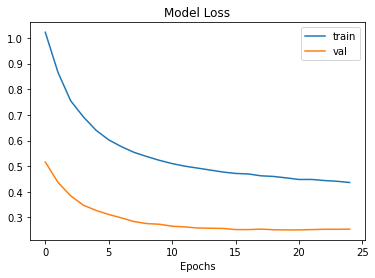

In [23]:
m1.plot_loss_function()

RMSE: 175.42
MAPE: 39.49%
MASE: 149.70%


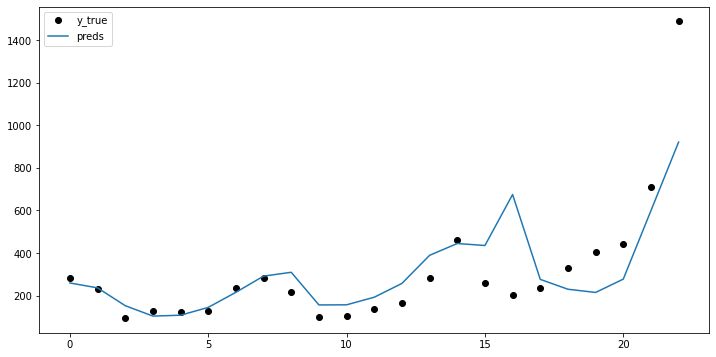

In [24]:
X_test = test_set[0]
y_preds = m1.predict(X_test) # Due to transform for NN model the test set loss the last 7 preds
y_preds = scaler.inverse_transform(y_preds).flatten()

y_train = np.concatenate([train,val]).flatten()
y_test = test.flatten()[:len(y_preds)] # Ensure the test set is the same length as the preds

print_metrics(y_test, y_preds, y_train)
plot_predictions(y_test, y_preds)

### Auto ML Model (Prophet)

Prophet is a library created by Facebook (now Meta) based on an additive model where "non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effectts" (See https://facebook.github.io/prophet/)

It is well known in the industry for the precision, speed and scalability of its models.

In [10]:
train_set = df[:-30]
test_set = df[-30:]

In [11]:
# There are evident peaks in the data, so we inpu them into the model as a variable "holidays"

holidays = pd.DataFrame(
    {
        "holiday": ["Christmas", "Christmas", "New Year", "New Year"],
        "ds": ["2016-12-24", "2017-12-24", "2016-12-31", "2017-12-31"],
    }
)

In [12]:
m2 = AutoMLModel("Prophet", yearly_seasonality=True, weekly_seasonality=True, holidays=holidays)
m2.fit(train_set)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.88756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1679.4    0.00103033        83.945           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1680.86   0.000625385       249.236   5.983e-06       0.001      294  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       1680.95   2.68433e-05       66.2475   3.752e-07       0.001      383  LS failed, Hessian reset 
     260       1680.95    4.1947e-08       62.4923      0.3166      0.3166      418   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [13]:
m2.plot_components()

In [14]:
forecast = m2.predict(periods=30, freq="D")
m2.plot_model_forecast(forecast)

RMSE: 144.57
MAPE: 33.67%
MASE: 127.15%


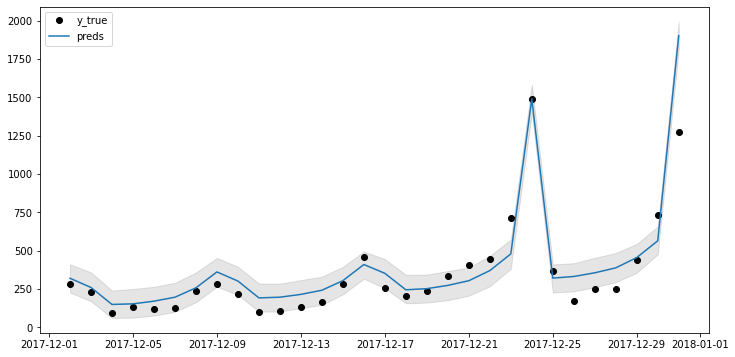

In [15]:
y_test = test_set.y.to_numpy()
y_preds = forecast.tail(len(test_set)).yhat.to_numpy()
y_train = train_set.y.to_numpy()

print_metrics(y_test, y_preds, y_train)
plot_prophet_predictions(test_set, forecast)

In [16]:
# Plot metrics comparable to the DeepLearning Model (23 steps)
print_metrics(y_test[:-7], y_preds[:-7], y_train)

RMSE: 78.98
MAPE: 31.86%
MASE: 89.29%


If we compare our first CNN approach with the Prophet model, we can see that
over simple CNN model (without holidays data) is close to the last one.
However, both models can be improved.
Here are some ideas to do it:
1. Use a more complex model (LSTM, GRU, RNN, or a mix of them)
2. Use a cross validation method to avoid overfitting
3. Add more features to the NN model, like holidays and seasonalities (eg. cos(day of the week))